In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
import matplotlib.backends.backend_pdf

sns.set_theme(color_codes=True)
sys.path.insert(0, ".././0.data-download/scripts/")

from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras

import blitzgsea as blitz
import urllib.request

# Download the gene set library here: https://github.com/MaayanLab/blitzgsea


2023-06-15 13:06:54.702975: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
# list available gene set libraries in Enrichr
blitz.enrichr.print_libraries()

{'LIBRARY_LIST_URL': 'https://maayanlab.cloud/speedrichr/api/listlibs', 'LIBRARY_DOWNLOAD_URL': 'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=text&libraryName='}
0 - GeneSigDB
1 - Enrichr_Submissions_TF-Gene_Coocurrence
2 - SysMyo_Muscle_Gene_Sets
3 - WikiPathway_2021_Human
4 - HomoloGene
5 - WikiPathways_2013
6 - PFOCR_Pathways_2023
7 - OMIM_Disease
8 - Data_Acquisition_Method_Most_Popular_Genes
9 - Cancer_Cell_Line_Encyclopedia
10 - WikiPathways_2016
11 - WikiPathways_2015
12 - RNAseq_Automatic_GEO_Signatures_Human_Up
13 - Human_Gene_Atlas
14 - KOMP2_Mouse_Phenotypes_2022
15 - Kinase_Perturbations_from_GEO_down
16 - Disease_Signatures_from_GEO_down_2014
17 - Disease_Perturbations_from_GEO_up
18 - Old_CMAP_down
19 - MCF7_Perturbations_from_GEO_up
20 - NIH_Funded_PIs_2017_GeneRIF_ARCHS4_Predictions
21 - DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019
22 - PPI_Hub_Proteins
23 - Disease_Signatures_from_GEO_up_2014
24 - GTEx_Tissue_Expression_Up
25 - L1000_Kinase_and_GPCR_Perturbati

In [4]:
# use enrichr submodule to retrieve gene set library
# these libraries are finicky to work with--they usually work the first time but then may stop working. You may need to remove the library from your computer and trying to reimport it to work again.
library = blitz.enrichr.get_library("GO_Biological_Process_2017")

In [5]:
# load the weight matrix 
gene_weight_dir = pathlib.Path("../2.train-VAE//results/weight_matrix_gsea.csv")
signature = pd.read_csv(gene_weight_dir)
print(signature.shape)
signature.head()

(1000, 101)


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,GPX4,-0.003431,-0.066462,0.023348,-0.087693,-0.035378,-0.130166,-0.011303,0.002215,0.065100,...,-0.122327,-0.089983,0.008672,-0.032056,-0.070818,-0.042180,-0.043921,0.070101,-0.021080,-0.009599
1,CCND1,0.041190,-0.036413,-0.073804,-0.003457,0.214047,0.094045,-0.096939,-0.046628,0.055162,...,0.073669,0.104024,0.006950,0.009301,0.074342,-0.054289,0.122823,-0.103081,-0.096315,0.040273
2,EP300,0.042926,-0.047306,-0.007981,0.092379,-0.049409,-0.051858,-0.000272,-0.015936,-0.088256,...,-0.071827,-0.009377,0.067449,-0.054565,0.000477,-0.000918,-0.092843,0.085447,-0.072340,0.031898
3,CDK6,0.025111,-0.041455,-0.056006,0.023690,-0.043088,-0.094552,0.011754,-0.006810,-0.007835,...,-0.105212,-0.081106,0.022533,-0.052183,-0.101708,-0.038274,-0.148809,-0.038718,-0.024035,0.003900
4,TXNRD1,0.000167,-0.018388,-0.069532,-0.096174,-0.059824,-0.032566,0.070643,0.013985,-0.008484,...,0.083347,0.030248,0.009382,0.011457,-0.023764,-0.003427,-0.043586,-0.049834,-0.042049,0.007481


In [6]:
all_GSEA_results = []
all_signatures = []
results = []

range = signature.shape[1]

for col in signature.iloc[:,1:range].columns:
    df = signature.iloc[:,[0,int(col)]]
    result = blitz.gsea(df, library)
    results.append(result)
    all_GSEA_results.append(result.assign(z_dim=f"z_{col}"))
    all_signatures.append(df)

In [7]:
# Generating negative control model for gsea

neg_signature = signature.iloc[:, 1:].copy()

for col in neg_signature.columns:
    neg_signature.loc[:, col] = np.random.permutation(neg_signature.loc[:, col].values)

genes = signature.iloc[:,:1]
neg_signature.insert(0,'0', genes)

neg_GSEA_results = []
negative_control = []

range = signature.shape[1]

for col in neg_signature.iloc[:,1:range].columns:
    neg_df = neg_signature.iloc[:,[0,int(col)]]
    neg_result = blitz.gsea(neg_df, library)
    neg_GSEA_results.append(neg_result.assign(z_dim=f"z_{col}"))
    negative_control.append(neg_df)

In [8]:
# stack up all of the results to be analyzed
all_GSEA_results= pd.concat(all_GSEA_results)
neg_GSEA_results = pd.concat(neg_GSEA_results)

In [9]:
# sort by what you want to evaluate
all_GSEA_results.sort_values(by='pval', ascending = True)
#neg_GSEA_results.sort_values(by='pval', ascending = True)

,es,nes,pval,sidak,fdr,geneset_size,leading_edge,z_dim
Term,,,,,,,,
mitochondrial translational elongation (GO:0070125),0.441050,7.125836,1.034531e-12,2.462185e-10,2.462185e-10,63,"DAP3,MRPL17,MRPL4,MRPL30,MRPL57,MRPL12,MRPS22,...",z_16
mitochondrial translational termination (GO:0070126),0.454397,6.960539,3.389793e-12,8.067707e-10,4.033853e-10,62,"DAP3,MRPL17,MRPL4,MRPL57,MRPL12,MRPS22,MRPS12,...",z_16
mitochondrial translational termination (GO:0070126),0.419474,6.470890,9.742735e-11,2.318771e-08,1.294431e-08,62,"MRPL57,MRPL4,MRPL55,MRPS16,MRPL58,MRPS10,MRPL1...",z_19
mitochondrial translational elongation (GO:0070125),0.396539,6.454223,1.087757e-10,2.588863e-08,1.294431e-08,63,"MRPL57,MRPL4,MRPL55,MRPS16,MRPL58,MRPS10,MRPL1...",z_19
mitochondrial translational elongation (GO:0070125),0.517818,6.385725,1.705879e-10,4.059991e-08,4.059991e-08,63,"MRPL57,MRPL43,MRPS16,MRPL16,MRPS24,MRPS18B,MRP...",z_99
...,...,...,...,...,...,...,...,...
positive regulation of type I interferon production (GO:0032481),-0.223079,-0.000000,1.000000e+00,1.000000e+00,1.000000e+00,6,"MRE11,POLR3D",z_65
regulation of cell cycle (GO:0051726),-0.210746,-0.000000,1.000000e+00,1.000000e+00,1.000000e+00,8,"EP300,LIN54",z_66
positive regulation of protein catabolic process (GO:0045732),-0.230918,-0.000000,1.000000e+00,1.000000e+00,1.000000e+00,5,"RAB7A,NDUFA13",z_66


Text(0.5, 1.0, 'Control Gene Set Enrichment Analysis')

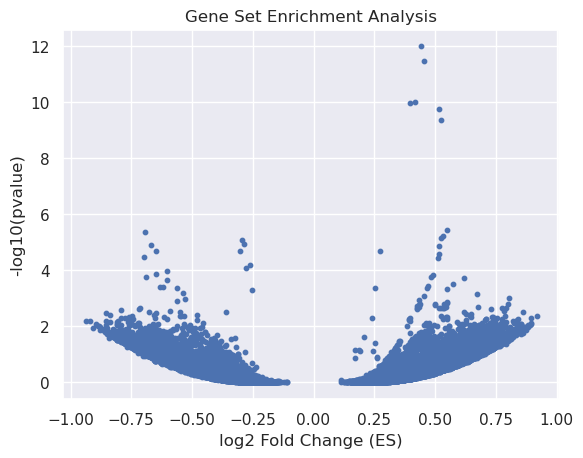

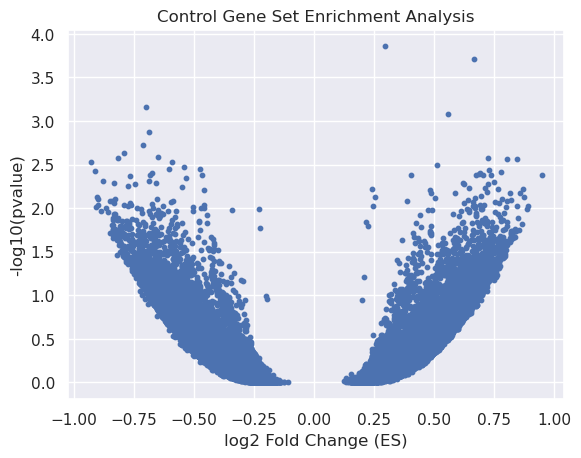

In [10]:
plt.figure()
plt.scatter(x=all_GSEA_results['es'],y=all_GSEA_results['pval'].apply(lambda x:-np.log10(x)),s=10)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(pvalue)')
plt.title('Gene Set Enrichment Analysis')

plt.figure()
plt.scatter(x=neg_GSEA_results['es'],y=neg_GSEA_results['pval'].apply(lambda x:-np.log10(x)), s=10)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(pvalue)')
plt.title('Control Gene Set Enrichment Analysis')

In [11]:
# Using VAE generated data

pdf_path = "../1.data-exploration/figures/gsea_plots.pdf"
pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_path)

for df in all_signatures:
    col_titles = df.columns.tolist()
    dim = col_titles[1]
    z_result = results[int(dim)-1]

    geneset = "mitochondrial translational elongation (GO:0070125)"

    text, ax = plt.subplots()
    ax.text(0.5, 0.5, 'The three following figures visualize the gene set enrichment analysis results for ' + geneset + ' in the latent dimension z=' + dim, fontsize=16, ha='center')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    pdf.savefig(text, bbox_inches='tight')
    plt.close()

    fig = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=False)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()


    fig_compact = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=True)
    pdf.savefig(fig_compact, bbox_inches='tight')
    plt.close()

    fig_table = blitz.plot.top_table(df, library, z_result, n=15)
    pdf.savefig(fig_table, bbox_inches='tight')
    plt.close()

pdf.close()


# Using negative control

ctrl_pdf_path = "../1.data-exploration/figures/ctrl_gsea_plots.pdf"
ctrl_pdf = matplotlib.backends.backend_pdf.PdfPages(ctrl_pdf_path)

for df in negative_control:
    col_titles = df.columns.tolist()
    dim = col_titles[1]
    z_result = results[int(dim)-1]

    geneset = "mitochondrial translational elongation (GO:0070125)"

    text, ax = plt.subplots()
    ax.text(0.5, 0.5, 'The three following figures visualize the negative control gene set enrichment analysis results for ' + geneset + ' in the latent dimension z=' + dim, fontsize=16, ha='center')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ctrl_pdf.savefig(text, bbox_inches='tight')
    plt.close()

    fig = blitz.plot.running_sum(df, "mitochondrial translational elongation (GO:0070125)", library, result=z_result, compact=False)
    ctrl_pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    fig_compact = blitz.plot.running_sum(df, "mitochondrial translational elongation (GO:0070125)", library, result=z_result, compact=True)
    ctrl_pdf.savefig(fig_compact, bbox_inches='tight')
    plt.close()

    fig_table = blitz.plot.top_table(df, library, z_result, n=15)
    ctrl_pdf.savefig(fig_table, bbox_inches='tight')
    plt.close()

ctrl_pdf.close()